In [5]:
!pip install pandas
!pip install xlrd==1.2.0
!pip install sklearn
!pip install seaborn
!pip install openpyxl


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [16]:
'''决策树分类模型
    先定义树节点类Node,再定义决策树类DecisionTree
'''
import numpy as np
import queue
import matplotlib.pyplot as plt      
from pandas.plotting import parallel_coordinates    #绘制多维数据的平行坐标
from pandas.plotting import radviz                  #绘制RadViz雷达图
import seaborn as sns                               #绘制多维数据的矩阵图和相关系数热力图

class Node:
    '''节点类
        由于属性都是连续值,连续属性离散化采用的是二分思想,因此决策树是二叉树,节点只有左右子树
        为了存储当前节点的最优划分属性及其对应的最优划分点,Node类加入了feature和value属性
        当Node为中间节点时,feature和value存储最优划分属性和值,left和right分别存储feature取值小于等于value和大于value的样本构成的Node
        当Node为叶节点时,feature存储分类标签,value无意义
    '''
    def __init__(self,feature,value,level=0,left=None,right=None):
        '''args:
            feature:最优划分属性(str)
            value:连续属性的最优划分点(float)
            left:左子树(Node)
            right:右子树(Node)
        '''
        self.feature=feature
        self.value=value
        self.level=level
        self.left=left
        self.right=right
        
    def Infm(self):
        '''决策树遍历树时打印节点信息'''
        infm='Level '+str(self.level)+'  feature:'+str(self.feature)+',value: '+str(self.value)
        return infm

class CART_clf:
    '''CART决策树类
        决策树类在初始化时只需要提供样本的基本数据,即属性值、属性名称、分类值
        为了方便建树时节点分割,D、Dv中均只存储各结点在整个类的训练集X中的索引
        为了防止过拟合,可以指定树的最大深度
        为了便于对测试集进行分类,建立属性值->索引的映射
    '''
    def __init__(self,X,y,feature_name,MaxLevel=10):
        '''args:
            X:训练样本的属性(list)
            y:训练样本的标签(list)
            feature_name:属性名称(list)
            MaxLevel:最大深度(int)
            feature_index:属性对应的索引
            root:决策树根节点
        '''
        self.X=X
        self.y=y
        self.feature_name=feature_name
        self.MaxLevel=MaxLevel
        self.feature_index=self.getFeatureIndex()
        self.root=None

    def Gini(self,Dv):
        '''Gini(Dv)=1-Σpk^2,k遍历不同的分类属性
            计算样本集Dv的纯度,即随机抽取的两个样本不属于一类的概率
            args:
                Dv:当前选定数据集的索引列表(list)
            return:
                Gini(Dv):基尼值(float)
        '''
        #根据Dv中索引号获取对应label
        label=np.array([self.y[i] for i in Dv])     #当前选定数据集Dv的标签
        #统计各feature在当前样本中占比
        if len(label)==0:
            return 1
        p=np.array([label[label==k].size/len(label) for k in set(label)])
        return 1-np.sum(p*p)

    def Gini_index(self,D,a,t):
        '''Gini_index(D,a)=ΣGini(Dv)*|Dv|/|D|,k遍历不同的属性取值
            由于是采用二分思想的连续属性离散化,因此属性取值只有两项
            D1={x in D | x.a<=t};D2={x in D | x.a>t}
            args:
                D:当前数据集D的索引列表(list)
                a:属性a在feature_name中的索引(int)
                t:属性a的二分边界值(float)
            return:
                Gini_index(D,a):基尼指数(float)
        '''
        D1=[x for x in D if self.X[x][a]<=t]
        D2=[x for x in D if self.X[x][a]>t]
        return D1,D2,(self.Gini(D1)*len(D1)+self.Gini(D2)*len(D2))/len(D)

    def Continuity2Discrete(self,Da):
        '''连续属性离散化:排序->计算相邻点中点
            args:
                Da:当前数据集D在属性a上的[索引,属性值]列表(list)
            return:
                Da_sort:对属性值进行排序的[索引,属性值]列表(list)
                T:候选划分点(list)
        '''
        Da_sort=sorted(Da,key=lambda x:x[1])        #对第1列(属性值)进行排序
        index=[x[0] for x in Da_sort]               #按属性值升序排列的数据在self.X中索引值
        A=[x[1] for x in Da_sort]                   #升序排列的属性值
        T=[(A[i]+A[i+1])/2 for i in range(len(A)-1)]#候选划分点
        return Da_sort,T

    def getBestSplit(self,D):
        '''寻找当前D中最优划分(属性及其对应二分边界)
            args:
                D:当前数据集D的索引列表(list)
            return:
                D1_final:左子树节点的索引列表(list)
                D2_final:右子树节点的索引列表(list)
                gini_index_final:最小基尼指数(float)
                a_final:最优划分属性的索引(int)
                t_final:最优划分属性的最优划分值(float)
        '''
        D1_final=None
        D2_final=None
        gini_index_final=float('inf')
        a_final=-1
        t_final=0
        for a in range(len(self.feature_name)):     #遍历属性
            Da=[[i,self.X[i][a]] for i in D]        #D中样本的属性a上取值的列表
            Da_sort,T=self.Continuity2Discrete(Da)  #返回对属性值进行排序的[索引,属性值]列表和候选划分点
            for t in T:
                D1,D2,gini_index=self.Gini_index(D,a,t)
                if gini_index<gini_index_final:
                    gini_index_final=gini_index
                    D1_final=D1
                    D2_final=D2
                    a_final=a
                    t_final=t
        return D1_final,D2_final,gini_index_final,a_final,t_final

    def BuildTree(self,D,level):
        '''递归建树
            args:
                D:当前数据集D的索引列表(list)
                level:当前深度(int)
                a:最优划分属性的索引(int)
                t:最优划分属性的最优划分值(float)
            return:
                root:建树的根节点(Node)
        '''
        if len(D)==0:
            return None
        label=[self.y[x] for x in D]              #当前数据集D的样本分类标签
        label_final=max(set(label),key=label.count)
        if level>=self.MaxLevel:                  #超过最大深度,直接停止,分类值为出现最多的label
            return Node(label_final,None,level)
        elif len(set(label))==1:
            return Node(self.y[D[0]],None,level)  #所有节点属于一个类,该节点为叶结点
        else:
            lc,rc,gini,a,t=self.getBestSplit(D)
            root=Node(self.feature_name[a],t,level)
            root.left=self.BuildTree(lc,level+1)
            root.right=self.BuildTree(rc,level+1)
            return root

    def Train(self):
        '''构建决策树,将根节点赋给self.root'''
        print('Start building CART.')
        D=[i for i in range(len(self.y))]
        self.root=self.BuildTree(D,0)
        print('Finish building CART.')
        return

    def preOrder(self,root):
        '''前序遍历决策树'''
        if root==None:
            return
        print(root.Infm())
        self.preOrder(root.left)
        self.preOrder(root.right)
        return

    def LevelOrder(self,root):
        q=queue.Queue()
        q.put(root)
        while(q.qsize()>0):
            node=q.get()
            print(node.Infm())
            if node.left is not None:
                q.put(node.left)
                q.put(node.right)
        return

    def getFeatureIndex(self):
        '''建立属性值->索引的映射,返回字典'''
        feature_dict={}
        for i in range(len(self.feature_name)):
            feature_dict[self.feature_name[i]]=i
        return feature_dict

    def Pred(self,x):
        '''对单一测试样本进行分类
            args:
                x:一个测试样本的属性(list)
            return:
                label:分类标签
        '''
        ptr=self.root
        while ptr is not None:
            if ptr.left is None and ptr.right is None:  #ptr为叶节点
                return ptr.feature
            fi=self.feature_index[ptr.feature]
            if x[fi]<=ptr.value:
                ptr=ptr.left
            else:
                ptr=ptr.right

    def Test(self,X_test,y_test):
        '''对测试集进行分类,统计准确率
            args:
                X_test:测试样本集的属性(list)
                y_test:测试样本集的分类标签
            return:
                acc:准确率
                y_pred:预测分类
        '''
        y_pred=[]                                   #记录预测分类
        cnt=0                                       #记录分类正确的样本数
        for i in range(len(X_test)):
            x=X_test[i]
            pred=self.Pred(x)
            y_pred.append(pred)
            if pred==y_test[i]:
                cnt+=1
        acc=cnt/len(y_test)
        return acc,y_pred

    def ParallelCoordinates(self,data_real,data_pred):
        '''绘制多维数据的平行坐标
            每条垂直的线代表一个属性,不同颜色的线表示不同的类别,每条折线表示一个样本
        '''
        fig=plt.figure(figsize=(13,4))
        ax=plt.subplot(121)
        plt.title('Real_label')
        parallel_coordinates(data_real,'Real_label')
        ax=plt.subplot(122)
        plt.title('Pred_label')
        parallel_coordinates(data_pred,'Pred_label')
        plt.show()

    def Radviz(self,data_real,data_pred):
        '''绘制RadViz雷达图,m个特征对应于单位圆上的m个点,圆中每一个散点代表表中一行数据
            每个散点上都有m条线分别连接到m个特征点上,而该特征的值就是这m条线上施加在散点上的力,使其受力平衡
        '''
        fig=plt.figure(figsize=(13,5))
        ax=plt.subplot(121)
        plt.title('Real_label')
        radviz(data_real,'Real_label',color=['blue','green','red'])
        ax=plt.subplot(122)
        plt.title('Pred_label')
        radviz(data_pred,'Pred_label',color=['blue','green','red'])
        plt.show()

    def Heatmap(self,data_real,data_pred):
        '''绘制相关系数热力图'''
        fig=plt.figure(figsize=(13,5))
        ax=plt.subplot(121)
        plt.title('Real_label')
        data_real_corr=data_real.corr()
        sns.heatmap(data_real_corr, annot=True)
        ax=plt.subplot(122)
        plt.title('Pred_label')
        data_pred_corr=data_pred.corr()
        sns.heatmap(data_pred_corr, annot=True)

        plt.show()

    def MatrixPlot(self,data_real,data_pred):
        '''绘制多维数据的矩阵图,表示不同特征之间的关系'''
        sns.pairplot(data_real,hue='Real_label')
        plt.show()
        sns.pairplot(data_pred,hue='Pred_label')
        plt.show()

Start building CART.
Finish building CART.
Accuracy of classification: 86.67%
Visualization of Decision Tree:
Level 0  feature:petal_length,value: 2.5999999999999996
Level 1  feature:Iris-setosa,value: None
Level 1  feature:petal_length,value: 4.8
Level 2  feature:Iris-versicolor,value: None
Level 2  feature:petal_width,value: 1.75
Level 3  feature:sepal_length,value: 6.5
Level 3  feature:Iris-virginica,value: None
Level 4  feature:Iris-virginica,value: None
Level 4  feature:Iris-versicolor,value: None
None


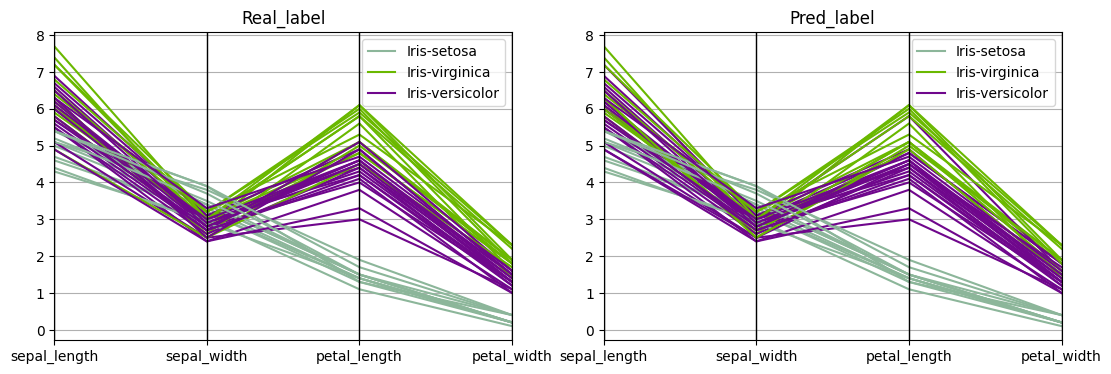

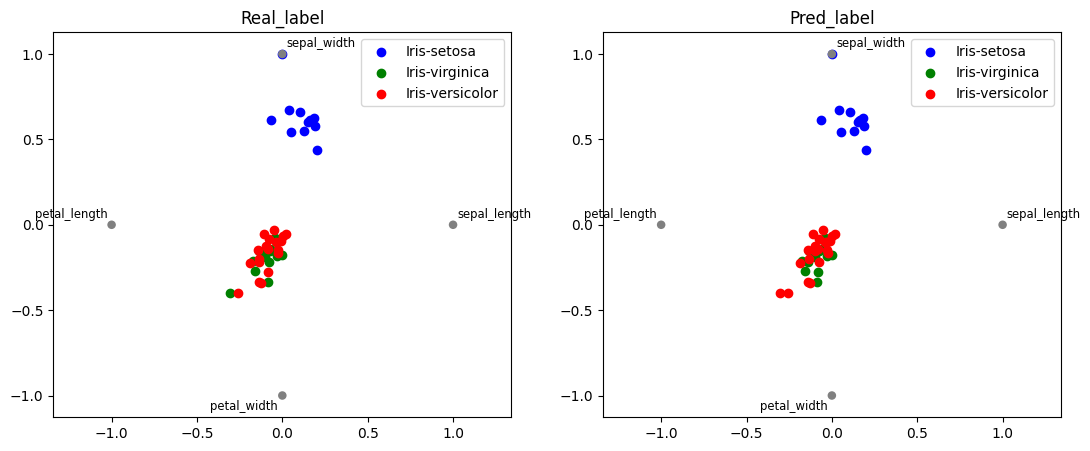

In [18]:
'''鸢尾花数据集
    150个样本,按7:3划分为训练集和测试集
    3个类别('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
    4个属性('sepal length','sepal width','petal length','petal width'),
    构建决策树分类模型并测试准确率
    呈现训练过程,绘制分类结果,评估模型准确性
'''
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split#随机划分样本集

#读取鸢尾花数据集
f=pd.read_excel(r'F:\code\code\python\exp3\data\iris_data.xlsx')
X=f.iloc[:,:4].values                               #属性值,numpy数组
y=f.iloc[:,4].values                                #标签值,numpy数组
feature_name=f.columns.tolist()[:4]                 #特征的列表
#按7:3划分训练集和测试集(numpy数组)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

#训练模型并计算准确率
cart=CART_clf(list(X_train),list(y_train),feature_name,4)
cart.Train()
acc,y_pred=cart.Test(list(X_test),list(y_test))
print('Accuracy of classification: %.2f%%'%(acc*100))
print('Visualization of Decision Tree:')
print(cart.LevelOrder(cart.root))

#将数据合并成[属性,标签]形式
data_real=[]
data_pred=[]
for i in range(len(y_test)):
    tmp1=list(X_test[i]).copy()
    tmp1.append(y_test[i])
    data_real.append(tmp1)
    tmp2=list(X_test[i]).copy()
    tmp2.append(y_pred[i])
    data_pred.append(tmp2)
tmp3=feature_name.copy()
tmp3.append('Real_label')
tmp4=feature_name.copy()
tmp4.append('Pred_label')
data_real=pd.DataFrame(data_real,columns=tmp3)
data_pred=pd.DataFrame(data_pred,columns=tmp4)

#绘制多维数据的平行坐标
cart.ParallelCoordinates(data_real,data_pred)

#绘制RadViz雷达图
cart.Radviz(data_real,data_pred)

#绘制相关系数热力图
# cart.Heatmap(data_real,data_pred)

#绘制所谓数据的矩阵图,表示不同特征之间的关系
# cart.MatrixPlot(data_real,data_pred)

前两张图都是呈现的真实标签和预测标签的对比，颜色为matplotlib默认颜色，2张子图的同一类别颜色可能相反。

Start building CART.
Finish building CART.
Accuracy of classification: 65.42%
Visualization of Decision Tree:
Level 0  feature:alcohol,value: 10.5
Level 1  feature:sulphates,value: 0.55
Level 1  feature:alcohol,value: 11.5
Level 2  feature:volatile acidity,value: 0.33
Level 2  feature:total sulfur dioxide,value: 81.0
Level 2  feature:sulphates,value: 0.58
Level 2  feature:sulphates,value: 0.68
Level 3  feature:chlorides,value: 0.082
Level 3  feature:sulphates,value: 0.52
Level 3  feature:volatile acidity,value: 0.36
Level 3  feature:free sulfur dioxide,value: 20.0
Level 3  feature:free sulfur dioxide,value: 15.0
Level 3  feature:total sulfur dioxide,value: 89.0
Level 3  feature:total sulfur dioxide,value: 15.0
Level 3  feature:free sulfur dioxide,value: 18.5
Level 4  feature:chlorides,value: 0.0595
Level 4  feature:total sulfur dioxide,value: 25.5
Level 4  feature:residual sugar,value: 9.0
Level 4  feature:density,value: 0.99744
Level 4  feature:total sulfur dioxide,value: 20.0
Level 4

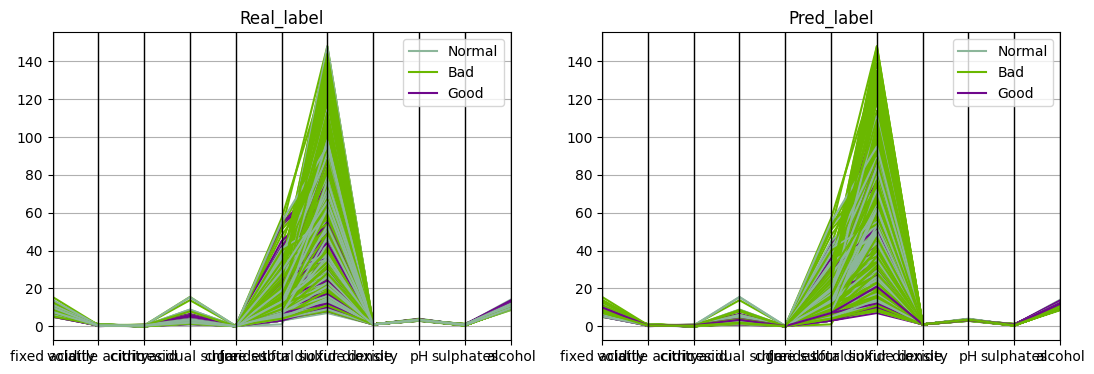

In [19]:
'''红酒品质数据集
    1599个样本,按7:3划分为训练集和测试集
    3个类别('Bad','Normal','Good')
    11个属性('fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol')
    构建决策树分类并测试准确率
    呈现训练过程,绘制分类结果,评估模型准确性
'''
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split#随机划分样本集

#读取红酒品质数据集
f=pd.read_excel(r'F:\code\code\python\exp3\data\winequality_data.xlsx')
X=f.iloc[:,:11].values              #属性值,numpy数组
y=f.iloc[:,11].values               #标签值,numpy数组
feature_name=f.columns.tolist()[:11]#特征的列表
#按7:3划分训练集和测试集(numpy数组)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

#训练模型并计算准确率
cart=CART_clf(list(X_train),list(y_train),feature_name,7)
cart.Train()
acc,y_pred=cart.Test(list(X_test),list(y_test))
print('Accuracy of classification: %.2f%%'%(acc*100))
print('Visualization of Decision Tree:')
print(cart.LevelOrder(cart.root))

#将数据合并成[属性,标签]形式
data_real=[]
data_pred=[]
for i in range(len(y_test)):
    tmp1=list(X_test[i]).copy()
    tmp1.append(y_test[i])
    data_real.append(tmp1)
    tmp2=list(X_test[i]).copy()
    tmp2.append(y_pred[i])
    data_pred.append(tmp2)
tmp3=feature_name.copy()
tmp3.append('Real_label')
tmp4=feature_name.copy()
tmp4.append('Pred_label')
data_real=pd.DataFrame(data_real,columns=tmp3)
data_pred=pd.DataFrame(data_pred,columns=tmp4)

#绘制多维数据的平行坐标
cart.ParallelCoordinates(data_real,data_pred)


In [22]:
'''决策树回归模型
    在决策树分类模型上加以改进,即可用于回归预测。
'''
import numpy as np
import queue
import matplotlib.pyplot as plt

class Node:
    '''节点类
        由于属性都是连续值,连续属性离散化采用的是二分思想,因此决策树是二叉树,节点只有左右子树
        为了存储当前节点的最优划分属性及其对应的最优划分点,Node类加入了feature和value属性
        当Node为中间节点时,feature和value存储最优划分属性和值,left和right分别存储feature取值小于等于value和大于value的样本构成的Node
        当Node为叶节点时,feature存储分类标签,value无意义
    '''
    def __init__(self,feature,value,level=0,left=None,right=None):
        '''args:
            feature:最优划分属性(str)
            value:连续属性的最优划分点(float)
            left:左子树(Node)
            right:右子树(Node)
        '''
        self.feature=feature
        self.value=value
        self.level=level
        self.left=left
        self.right=right
        
    def Infm(self):
        '''决策树遍历树时打印节点信息'''
        infm='Level '+str(self.level)+'  feature:'+str(self.feature)+',value: '+str(self.value)
        return infm

class CART_reg:
    '''CART决策树类
        决策树类在初始化时只需要提供样本的基本数据,即属性值、属性名称、回归值
        为了方便建树时节点分割,R、Rj中均只存储各结点在整个类的训练集X中的索引
        为了防止过拟合,可以指定树的最大深度
        为了便于对测试集进行分类,建立属性值->索引的映射
    '''
    def __init__(self,X,y,feature_name,MaxLevel=10):
        '''args:
            X:训练样本的属性(list)
            y:训练样本的回归值(list)
            feature_name:属性名称(list)
            MaxLevel:最大深度(int)
            feature_index:属性对应的索引
            root:决策树根节点
        '''
        self.X=X
        self.y=y
        self.feature_name=feature_name
        self.MaxLevel=MaxLevel
        self.feature_index=self.getFeatureIndex()
        self.root=None

    def getRSS(self,R,j,s):
        '''RSS=Σ(R1)(yi-yRj)^2+Σ(R2)(yi-yRj)^2
            R1={x in R | x.j<=s};R2={x in R | x.j>s}
            args:
                R:当前数据集R的索引列表(list)
                j:属性j在feature_name中的索引(int)
                s:属性j的二分边界值(float)
            return:
                RSS(R,j,s):RSS(float)
        '''
        R1=[x for x in R if self.X[x][j]<=s]
        R2=[x for x in R if self.X[x][j]>s]
        YR1=np.mean(np.array([self.y[i] for i in R1]))
        YR2=np.mean(np.array([self.y[i] for i in R2]))
        Y1=[self.y[i] for i in R1]
        Y2=[self.y[i] for i in R2]
        RSS=np.sum(np.square(Y1-YR1))+np.sum(np.square(Y2-YR2))
        return R1,R2,RSS

    def Continuity2Discrete(self,Rj):
        '''连续属性离散化:排序->计算相邻点中点
            args:
                Rj:当前数据集R在属性j上的[索引,属性值]列表(list)
            return:
                Rj_sort:对属性值进行排序的[索引,属性值]列表(list)
                S:候选划分点(list)
        '''
        Rj_sort=sorted(Rj,key=lambda x:x[1])        #对第1列(属性值)进行排序
        index=[x[0] for x in Rj_sort]               #按属性值升序排列的数据在self.X中索引值
        J=[x[1] for x in Rj_sort]                   #升序排列的属性值
        S=[(J[i]+J[i+1])/2 for i in range(len(J)-1)]#候选划分点
        return Rj_sort,S

    def getBestSplit(self,R):
        '''寻找当前R中最优划分(属性及其对应二分边界)
            args:
                R:当前数据集R的索引列表(list)
            return:
                R1_final:左子树节点的索引列表(list)
                R2_final:右子树节点的索引列表(list)
                RSS:最小基尼指数(float)
                j_final:最优划分属性的索引(int)
                s_final:最优划分属性的最优划分值(float)
        '''
        R1_final=None
        R2_final=None
        RSS_final=float('inf')
        j_final=-1
        s_final=0
        for j in range(len(self.feature_name)):     #遍历属性
            Rj=[[i,self.X[i][j]] for i in R]        #D中样本的属性a上取值的列表
            Rj_sort,S=self.Continuity2Discrete(Rj)  #返回对属性值进行排序的[索引,属性值]列表和候选划分点
            for s in S:
                R1,R2,RSS=self.getRSS(R,j,s)
                if RSS<RSS_final:
                    RSS_final=RSS
                    R1_final=R1
                    R2_final=R2
                    j_final=j
                    s_final=s
                # print(j_final,s_final)
        return R1_final,R2_final,RSS_final,j_final,s_final

    def BuildTree(self,R,level):
        '''递归建树
            args:
                R:当前数据集R的索引列表(list)
                level:当前深度(int)
                j:最优划分属性的索引(int)
                s:最优划分属性的最优划分值(float)
            return:
                root:建树的根节点(Node)
        '''
        if len(R)==0:
            return None
        reg=[self.y[x] for x in R]                #当前数据集R的样本分类标签
        reg_final=np.mean(np.array(reg))
        if level>=self.MaxLevel:                  #超过最大深度,直接停止,回归值为reg的均值
            return Node(reg_final,None,level)
        elif len(R)==1:
            return Node(self.y[R[0]],None,level)  #所有节点属于一个类,该节点为叶结点
        else:
            lc,rc,RSS,j,s=self.getBestSplit(R)
            # print(RSS,j,s)
            root=Node(self.feature_name[j],s,level)
            root.left=self.BuildTree(lc,level+1)
            root.right=self.BuildTree(rc,level+1)
            return root

    def Train(self):
        '''构建决策树,将根节点赋给self.root'''
        print('Start building CART.')
        R=[i for i in range(len(self.y))]
        self.root=self.BuildTree(R,0)
        print('Finish building CART.')
        return

    def preOrder(self,root):
        '''前序遍历决策树'''
        if root==None:
            return
        print(root.Infm())
        self.preOrder(root.left)
        self.preOrder(root.right)
        return

    def LevelOrder(self,root):
        q=queue.Queue()
        q.put(root)
        while(q.qsize()>0):
            node=q.get()
            print(node.Infm())
            if node.left is not None:
                q.put(node.left)
                q.put(node.right)
        return

    def getFeatureIndex(self):
        '''建立属性值->索引的映射,返回字典'''
        feature_dict={}
        for i in range(len(self.feature_name)):
            feature_dict[self.feature_name[i]]=i
        return feature_dict

    def Pred(self,x):
        '''对单一测试样本进行分类
            args:
                x:一个测试样本的属性(list)
            return:
                label:分类标签
        '''
        ptr=self.root
        while ptr is not None:
            if ptr.left is None and ptr.right is None:  #ptr为叶节点
                return ptr.feature
            fi=self.feature_index[ptr.feature]
            if x[fi]<=ptr.value:
                ptr=ptr.left
            else:
                ptr=ptr.right

    def Test(self,X_test,y_test):
        '''对测试集进行分类,统计准确率
            args:
                X_test:测试样本集的属性(list)
                y_test:测试样本集的真实回归值
            return:
                R_square:R^2值
                y_pred:预测结果
        '''
        y_pred=[]                                   #记录预测结果
        top=0                                       #分子
        bottom=0                                    #分母
        yi=np.mean(np.array(y_test))                #真实回归值的均值
        for i in range(len(X_test)):
            pred=self.Pred(X_test[i])
            y_pred.append(pred)
            top+=(y_test[i]-pred)*(y_test[i]-pred)
            bottom+=(y_test[i]-yi)*(y_test[i]-yi)
        return 1-top/bottom,y_pred

    def Plt(self,y_test,y_pred):
        '''回归结果可视化'''
        x=np.array([i for i in range(len(y_pred))])
        plt.plot(x,y_test,y_pred)
        plt.ylabel('Real & Pred')
        plt.xlabel('number of sample')
        plt.legend(['Real','Pred'])
        plt.show()

Start building CART.
Finish building CART.
R_square of regression: 0.96
Visualization of Decision Tree:
Level 0  feature:Temperature,value: 22.55788767
Level 1  feature:Temperature,value: 15.632273945
Level 1  feature:Temperature,value: 32.055722474999996
Level 2  feature:Temperature,value: 9.191591923499999
Level 2  feature:Temperature,value: 18.794326855
Level 2  feature:Temperature,value: 27.71324961
Level 2  feature:Temperature,value: 36.073559169999996
Level 3  feature:Temperature,value: 6.3182058009999995
Level 3  feature:Temperature,value: 13.985660240000001
Level 3  feature:Temperature,value: 16.850870375
Level 3  feature:Temperature,value: 20.747025645
Level 3  feature:Temperature,value: 25.353764605
Level 3  feature:Temperature,value: 29.743369845
Level 3  feature:Temperature,value: 33.629374255
Level 3  feature:Temperature,value: 39.652018765
Level 4  feature:Temperature,value: 5.580372509
Level 4  feature:Temperature,value: 8.612512017
Level 4  feature:Temperature,value: 10

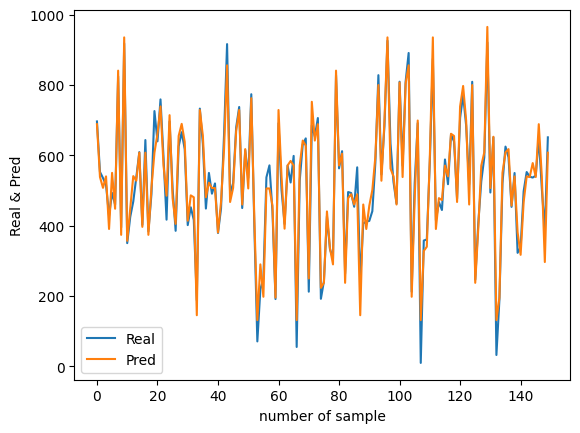

In [23]:
'''冰淇淋数据集
    500个样本,按7:3划分为训练集和测试集
    回归任务,预测Revenue
    1个属性('Temperature'),
    构建决策树回归模型并测试准确率
    呈现训练过程,评估模型准确性
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    #随机划分样本集

#读取房价数据集
f=pd.read_excel(r'F:\code\code\python\exp3\data\icecream_data.xlsx')
X=f.iloc[:,:1].values               #属性值,numpy数组
y=f.iloc[:,1].values                #标签值,numpy数组
feature_name=f.columns.tolist()[:1] #特征的列表
#按7:3划分训练集和测试集(numpy数组)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

#训练模型并计算R^2
cart=CART_reg(list(X_train),list(y_train),feature_name,8)
cart.Train()
R_square,y_pred=cart.Test(list(X_test),list(y_test))
print('R_square of regression: %.2f'%R_square)
print('Visualization of Decision Tree:')
print(cart.LevelOrder(cart.root))

#绘制回归结果
cart.Plt(y_test,y_pred)

Start building CART.


f:\Python\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Finish building CART.
R_square of regression: 0.61
Visualization of Decision Tree:
Level 0  feature:AveRooms,value: 6.37430514622534
Level 1  feature:Latitude,value: 37.92
Level 1  feature:AveBedrooms,value: 1.2182056924578
Level 2  feature:Longitude,value: -121.87
Level 2  feature:Latitude,value: 38.885000000000005
Level 2  feature:AveRooms,value: 7.393322318601125
Level 2  feature:Latitude,value: 33.715
Level 3  feature:Longitude,value: -122.31
Level 3  feature:Latitude,value: 34.47
Level 3  feature:Longitude,value: -122.38
Level 3  feature:Longitude,value: -121.39
Level 3  feature:Latitude,value: 37.98
Level 3  feature:HouseAge,value: 26.0
Level 3  feature:Longitude,value: -116.9
Level 3  feature:Latitude,value: 39.379999999999995
Level 4  feature:Latitude,value: 37.76
Level 4  feature:Latitude,value: 37.58
Level 4  feature:Longitude,value: -118.32
Level 4  feature:Longitude,value: -121.32
Level 4  feature:Latitude,value: 38.1
Level 4  feature:AveRooms,value: 5.4425039872408245
Leve

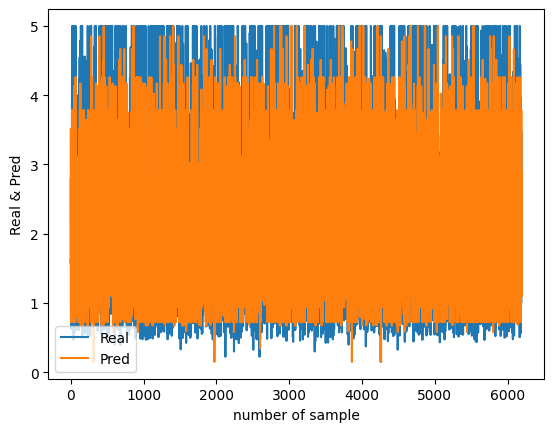

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    #随机划分样本集

#读取房价数据集
f=pd.read_excel(r'F:\code\code\python\exp3\data\housing_data.xlsx')
X=f.iloc[:,:5].values               #属性值,numpy数组
y=f.iloc[:,5].values                #标签值,numpy数组
feature_name=f.columns.tolist()[:5] #特征的列表
#按7:3划分训练集和测试集(numpy数组)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

#训练模型并计算R^2
cart=CART_reg(list(X_train),list(y_train),feature_name,7)
cart.Train()
R_square,y_pred=cart.Test(list(X_test),list(y_test))
print('R_square of regression: %.2f'%R_square)
print('Visualization of Decision Tree:')
print(cart.LevelOrder(cart.root))

#绘制回归结果
cart.Plt(y_test,y_pred) 

上面单元格的房价数据集回归可以跑，但是相当费时，预计2h起步，原因与分析见实验报告。我当时在modelarts上用顶配notebook运行了近3个小时出了结果，但是不小心清除了...因为太耗时了，就没有再跑一遍来将结果呈现在ipynb中。报告中的结果是本地VS Code的运行结果，因为不受网络限制。